# Image Classification with ResNet

In [6]:
import torch
from lightning.pytorch import Trainer
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.loggers import WandbLogger

from matplotlib import pyplot as plt
from hydra.utils import instantiate

from omegaconf import OmegaConf
from rich import print
import wandb

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Module

In [3]:
cfg = OmegaConf.load('../config/data/image/mnist.yaml')

In [4]:
cfg.batch_size = 128
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()

[17:08:50] INFO - Init ImageDataModule for mnist
[17:09:04] INFO - split train into train/val [0.8, 0.2]
[17:09:04] INFO - train: 48000 val: 12000, test: 10000


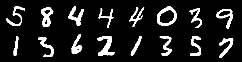

In [5]:
xb, yb = next(iter(dm.train_dataloader()))
dm.show_batch(xb[:16])

## Model

In [7]:
cfg_model = OmegaConf.load('../config/model/image/resnetx.yaml')
cfg_model.nnet.n_features = [1, 8, 16, 32, 16]
print(OmegaConf.to_yaml(cfg_model))
model = instantiate(cfg_model)

_target_: nimrod.models.conv.ConvNetX
_partial_: true
num_classes: 10
nnet:
  _target_: nimrod.models.conv.ConvNet
  n_features:
  - 1
  - 8
  - 16
  - 32
  - 16
  num_classes: ${..num_classes}
  kernel_size: 3
  bias: null
  normalization:
    _target_: hydra.utils.get_class
    path: torch.nn.BatchNorm2d
  activation:
    _target_: hydra.utils.get_class
    path: torch.nn.ReLU

In [8]:
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H, W)
nnet = instantiate(cfg_model.nnet)
nnet(X).shape

torch.Size([64, 10])

## Optimizer

In [9]:
cfg_sched = OmegaConf.load('../config/scheduler/one_cycle_lr.yaml')
scheduler = instantiate(cfg_sched)
print(OmegaConf.to_yaml(cfg_sched))

_target_: torch.optim.lr_scheduler.OneCycleLR
_partial_: true
max_lr: 0.01
total_steps: null
pct_start: 0.3
anneal_strategy: cos
div_factor: 10
three_phase: false

In [10]:
cfg = OmegaConf.load('../config/optimizer/adam_w.yaml')
optimizer = instantiate(cfg)
print(OmegaConf.to_yaml(cfg))

_target_: torch.optim.AdamW
_partial_: true
lr: 0.0001
weight_decay: 1.0e-05

## Training

In [11]:
cfg = OmegaConf.load('../config/callbacks/learning_rate_monitor.yaml')
lr_monitor = instantiate(cfg.learning_rate_monitor)
print(type(lr_monitor))
print(OmegaConf.to_yaml(cfg))

<class 'lightning.pytorch.callbacks.lr_monitor.LearningRateMonitor'>

learning_rate_monitor:
  _target_: lightning.pytorch.callbacks.LearningRateMonitor
  logging_interval: step

## LR Finder

[17:28:53] INFO - ConvNetX: init
[17:28:53] INFO - Classifier: init
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
[17:29:07] INFO - Optimizer: <class 'torch.optim.adamw.AdamW'>
[17:29:07] INFO - Scheduler: <class 'torch.optim.lr_scheduler.OneCycleLR'>
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many worker

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.02818382931264452
Restoring states from the checkpoint path at /Users/slegroux/Projects/nimrod/tutorials/.lr_find_2356128e-145e-4d6d-a5ca-2bdac9fdc278.ckpt
Restored all states from the checkpoint at /Users/slegroux/Projects/nimrod/tutorials/.lr_find_2356128e-145e-4d6d-a5ca-2bdac9fdc278.ckpt


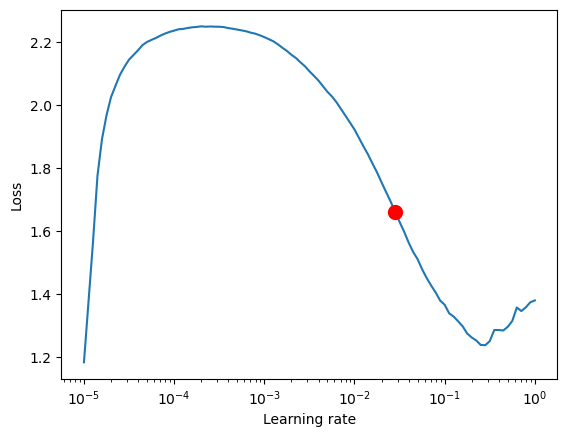

Suggested learning rate: 0.02818382931264452

In [16]:
# LR_FINDER

cfg_model.nnet.n_features = [1, 8, 16, 32, 16]
N_EPOCHS = 5
cfg_sched.total_steps = len(dm.train_dataloader()) * N_EPOCHS

scheduler = instantiate(cfg_sched)
model = instantiate(cfg_model)(optimizer=optimizer, scheduler=scheduler)

trainer = Trainer(
    accelerator="auto",
    # max_epochs=N_EPOCHS,
    check_val_every_n_epoch=1,
    log_every_n_steps=1
    )

tuner = Tuner(trainer)
lr_finder = tuner.lr_find(
    model,
    datamodule=dm,
    min_lr=1e-5,
    max_lr=1.0,
    num_training=100,  # number of iterations
    # attr_name="optimizer.lr",
)
fig = lr_finder.plot(suggest=True)
plt.show()
print(f"Suggested learning rate: {lr_finder.suggestion()}")


## one cycle train

In [18]:
# ONE-CYCLE TRAIN

cfg_model.nnet.n_features = [1, 8, 16, 32, 16]
N_EPOCHS = 5
cfg_sched.total_steps = len(dm.train_dataloader()) * N_EPOCHS
cfg_sched.max_lr = lr_finder.suggestion()

wandb_logger = WandbLogger(
    project="MNIST Classification",
    name=f"resnetx-bs:{dm.batch_size}-epochs:{N_EPOCHS}-features:{cfg_model.nnet.n_features}",
    save_dir='wandb',
    entity='slegroux',
    tags=['arch', 'dev'],
    group='resnetx',
    )

trainer = Trainer(
    accelerator="auto",
    max_epochs=N_EPOCHS,
    logger=wandb_logger,
    callbacks = [lr_monitor],
    check_val_every_n_epoch=1,
    log_every_n_steps=1
    )

scheduler = instantiate(cfg_sched)
model = instantiate(cfg_model)(optimizer=optimizer, scheduler=scheduler)

trainer.fit(model, dm.train_dataloader(), dm.val_dataloader())
trainer.test(model, dm.test_dataloader())
wandb.finish()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[18:23:35] INFO - ConvNetX: init
[18:23:35] INFO - Classifier: init
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.


[18:23:37] INFO - Optimizer: <class 'torch.optim.adamw.AdamW'>
[18:23:37] INFO - Scheduler: <class 'torch.optim.lr_scheduler.OneCycleLR'>

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | nnet         | ConvNet            | 12.0 K | train
1 | loss         | CrossEntropyLoss   | 0      | train
2 | train_acc    | MulticlassAccuracy | 0      | train
3 | val_acc      | MulticlassAccuracy | 0      | train
4 | test_acc     | MulticlassAccuracy | 0      | train
5 | train_loss   | MeanMetric         | 0      | train
6 | val_loss     | MeanMetric         | 0      | train
7 | test_loss    | MeanMetric         | 0      | train
8 | val_acc_best | MaxMetric          | 0      | train
------------------------------------------------------------
12.0 K    Trainable params
0         Non-trainable params
12.0 K    Total params
0.048     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9908000230789185     │
│         test/loss         │   0.029160941019654274    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▆▆██████████
lr-AdamW,▂▂▂▃▆▆█████▇▇▇▇▆▆▆▆▅▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
test/acc,▁
test/loss,▁
train/acc_epoch,▁▅▇▇█
train/acc_step,▁▆▆▅▅▅▅▆▅██▆▅▅▅▆▇██▅▆▆█▇▆▆▇▆▅█▇██▇█▇█▇▇▆
train/loss_epoch,█▃▂▁▁
train/loss_step,█▃▄▂▂▂▃▃▁▂▂▁▃▂▄▂▁▂▁▁▂▁▁▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█████
val/acc,▁▄▆██
val/acc_best,▁▄▆██
